# 0. Instructions and setup

## 0.1. Instructions. Part 3: State of the Art Comparison (2 points)

- **Objective:** Benchmark your model against the SOA with the full dataset now available.

- **Tasks:**
  - **a. Full Dataset Training (0.25 points):** Incrementally train your model with varying percentages of the full dataset (1%, 10%, 25%, 50%, 75%, and 100%). Record the results.
  - **b. Learning Curve (0.25 points):** Plot a learning curve based on the training data percentages.
  - **c. Technique Comparison (0.5 points):** Incorporate the techniques tested in Part 2 into your training schema for comparison.
  - **d. Methodology Analysis (1 point):** Analyze and compare all methods employed. Discuss the effectiveness and limitations observed.

## 0.2. Libraries

In [8]:
import numpy as np
import polars as pl
from library.utilities import set_seed, sample_balanced_dataset
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import (
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments,
)
from library.incremental_train.doc import run_incremental_training, train_with_percentage

In [2]:
# # specific for mac users with M1 chip (That do not have CUDA)
# # !pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu
# import torch
# print(torch.backends.mps.is_available())      # Is Metal available?
# print(torch.backends.mps.is_built()) 

In [3]:
# # detect if MPS (GPU in Mac) is available
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# x = torch.ones(3, 3).to(device)
# print(x)

In [4]:
# Set random seed for reproducibility
seed = 42
set_seed(42)

Seed set to 42. This ensures reproducibility of results across runs.


# 1. Full dataset training: Incrementally train your mode

In [5]:
# Load the cleaned Parquet file
df = pl.read_parquet('data/FRENCH_swiss_judgment_prediction_combined.parquet')

# Display the loaded DataFrame
print("\nLoaded DataFrame shape:", df.shape)
print("\nLoaded DataFrame schema:")
print(df.schema)
print("\nFirst few rows of the loaded DataFrame:")
df.head()


Loaded DataFrame shape: (31094, 9)

Loaded DataFrame schema:
Schema({'id': Int32, 'year': Int32, 'text': String, 'labels': Int64, 'language': String, 'region': String, 'canton': String, 'legal area': String, 'split': String})

First few rows of the loaded DataFrame:


id,year,text,labels,language,region,canton,legal area,split
i32,i32,str,i64,str,str,str,str,str
0,2000,"""A.- Par contrat d'entreprise s…",0,"""fr""",null,null,"""civil law""","""train"""
1,2000,"""A.- Le 12 avril 1995, A._ a su…",0,"""fr""",null,null,"""insurance law""","""train"""
2,2000,"""A.- En février 1994, M._ a été…",0,"""fr""","""Région lémanique""","""ge""","""insurance law""","""train"""
3,2000,"""A.- M._ a travaillé en qualité…",0,"""fr""",null,null,"""insurance law""","""train"""
6,2000,"""A.- Le 29 septembre 1997, X._ …",0,"""fr""","""Espace Mittelland""","""ne""","""penal law""","""train"""


In [6]:
# Split the DataFrame into training, validation and test sets
train_df = df.filter(pl.col('split') == 'train')
val_df = df.filter(pl.col('split') == 'validation')
test_df = df.filter(pl.col('split') == 'test')

# Delete the original data to free up memory
del df

In [5]:
# # Load the train, validation and test Parquet files
# train_df = pl.read_parquet('data/FRENCH_swiss_judgment_prediction_train.parquet')
# valid_df = pl.read_parquet('data/FRENCH_swiss_judgment_prediction_valid.parquet')
# test_df = pl.read_parquet('data/FRENCH_swiss_judgment_prediction_test.parquet')

# # Display the loaded DataFrames
# print("\nTrain DataFrame shape:", train_df.shape)
# print("\nValidation DataFrame shape:", valid_df.shape)
# print("\nTest DataFrame shape:", test_df.shape)

# print("\nTrain DataFrame schema:")
# print(train_df.schema)
# print("\nFirst few rows of the train DataFrame:")
# train_df.head()

In [5]:
model_name = "almanach/camembert-base"  # Path to the pre-trained model
num_labels = 2  # Number of labels for the classification task (in this case, binary classification)
max_length = min(int(AutoModel.from_pretrained(model_name).config.max_position_embeddings), 512)  # Maximum length of the input sequences (truncation if larger than this). Set dynamically based on the chosen model.

print(f"Model: {model_name}, Max Length: {max_length}")

Model: almanach/camembert-base, Max Length: 512


In [ ]:
result1 = train_with_percentage(train_df, val_df, 1, model_name, max_length, num_labels, seed)

In [ ]:
result10 = train_with_percentage(train_df, val_df, 10, model_name, max_length, num_labels, seed)

In [ ]:
result25 = train_with_percentage(train_df, val_df, 25, model_name, max_length, num_labels, seed)

In [6]:
# Note that, due to the class imbalance, we will have to do sampling with replacement
# to get enough samples for the minority class
result50 = train_with_percentage(train_df, val_df, 50, model_name, max_length, num_labels, seed)

Using sampling with replacement for positive class (need 5294, have 5197)


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/10588 [00:00<?, ? examples/s]

Map:   0%|          | 0/3095 [00:00<?, ? examples/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at almanach/camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.658000,0.794177,0.485945,0.385477,0.257216,0.768875
2,0.586400,0.646257,0.623263,0.383721,0.292035,0.559322
3,0.480600,0.760664,0.614540,0.398992,0.296407,0.610169
4,0.375800,0.846607,0.649111,0.410423,0.316848,0.582435
5,0.290200,0.849848,0.672375,0.401417,0.325359,0.523883
6,0.239100,1.258928,0.581583,0.396833,0.284379,0.656394
7,0.191100,1.214160,0.623910,0.408537,0.304776,0.619414


In [7]:
# Note that, due to the class imbalance, we will have to do sampling with replacement
# to get enough samples for the minority class
result75 = train_with_percentage(train_df, val_df, 75, model_name, max_length, num_labels, seed)

Using sampling with replacement for positive class (need 7942, have 5197)


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/15884 [00:00<?, ? examples/s]

Map:   0%|          | 0/3095 [00:00<?, ? examples/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at almanach/camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.623500,0.590011,0.679806,0.386378,0.322981,0.480740
2,0.524000,0.604952,0.708562,0.368347,0.337612,0.405239
3,0.430100,0.718164,0.663328,0.355995,0.297214,0.443760
4,0.321100,0.835823,0.652342,0.364817,0.295694,0.476117
5,0.266000,0.867743,0.705008,0.366412,0.333333,0.406780
6,0.215700,1.084933,0.651373,0.375940,0.300926,0.500770


In [8]:
# Note that, due to the class imbalance, we will have to do sampling with replacement
# to get enough samples for the minority class
result100 = train_with_percentage(train_df, val_df, 100, model_name, max_length, num_labels, seed)

Using sampling with replacement for positive class (need 10589, have 5197)


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/21178 [00:00<?, ? examples/s]

Map:   0%|          | 0/3095 [00:00<?, ? examples/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at almanach/camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.630000,0.633844,0.656866,0.395216,0.313460,0.534669
2,0.481600,0.647722,0.693376,0.359217,0.319712,0.409861
3,0.381200,0.741087,0.682714,0.370513,0.317234,0.445300
4,0.260200,0.950179,0.666882,0.376286,0.309761,0.479199
5,0.222100,1.031830,0.677221,0.361661,0.308952,0.436055
6,0.165900,1.173391,0.663328,0.358374,0.298462,0.448382


# 2.  Learning Curve

## 2.1. Learning Curve for different percentages

In [16]:
# First, we load all of the results for each of the different percentages
results1 = pl.read_parquet(os.path.join('results', 'part_3', 'a', 'cls_fine_tuning_results_camembert-base_1pct.parquet'))
results10 = pl.read_parquet(os.path.join('results', 'part_3', 'a', 'cls_fine_tuning_results_camembert-base_10pct.parquet'))
results25 = pl.read_parquet(os.path.join('results', 'part_3', 'a', 'cls_fine_tuning_results_camembert-base_25pct.parquet'))
results50 = pl.read_parquet(os.path.join('results', 'part_3', 'a', 'cls_fine_tuning_results_camembert-base_50pct.parquet'))
results75 = pl.read_parquet(os.path.join('results', 'part_3', 'a', 'cls_fine_tuning_results_camembert-base_75pct.parquet'))
results100 = pl.read_parquet(os.path.join('results', 'part_3', 'a', 'cls_fine_tuning_results_camembert-base_100pct.parquet'))

# Create a list to store the summary data for each percentage
summary_data = []

# Define the percentage and corresponding result dataframes
percentage_results = [
    (1, results1),
    (10, results10),
    (25, results25),
    (50, results50),
    (75, results75),
    (100, results100)
]

# Extract metrics for each percentage
for percentage, result_df in percentage_results:
    # Find the best epoch (lowest eval_loss)
    best_epoch_idx = result_df['eval_loss'].arg_min()  # Get the index of the best epoch
    best_epoch = result_df[best_epoch_idx]
    
    # Add to summary data
    summary_data.append({
        'percentage': percentage,
        'eval_loss': best_epoch['eval_loss'][0],
        'eval_accuracy': best_epoch['eval_accuracy'][0],
        'eval_f1': best_epoch['eval_f1'][0],
        'eval_precision': best_epoch['eval_precision'][0],
        'eval_recall': best_epoch['eval_recall'][0]
    })

# Create the summary DataFrame
summary_df = pl.DataFrame(summary_data)
display(summary_df)

percentage,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall
i64,f64,f64,f64,f64,f64
1,0.632334,0.670436,0.234234,0.228404,0.24037
10,0.57981,0.707593,0.386441,0.345036,0.439137
25,0.577443,0.685299,0.383544,0.325456,0.466872
50,0.646257,0.623263,0.383721,0.292035,0.559322
75,0.590011,0.679806,0.386378,0.322981,0.48074
100,0.633844,0.656866,0.395216,0.31346,0.534669


In [17]:
import matplotlib.pyplot as plt

def plot_learning_curve(summary_df, metric='eval_accuracy'):
    """
    Plots a learning curve for the given metric from the summary DataFrame.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(summary_df['percentage'], summary_df[metric], marker='o', label=metric)
    plt.xlabel('Percentage of Training Data Used')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'Learning Curve: {metric.replace("_", " ").title()} vs. Training Set Size')
    plt.grid(True)
    plt.xticks(summary_df['percentage'])
    plt.legend()
    plt.show()

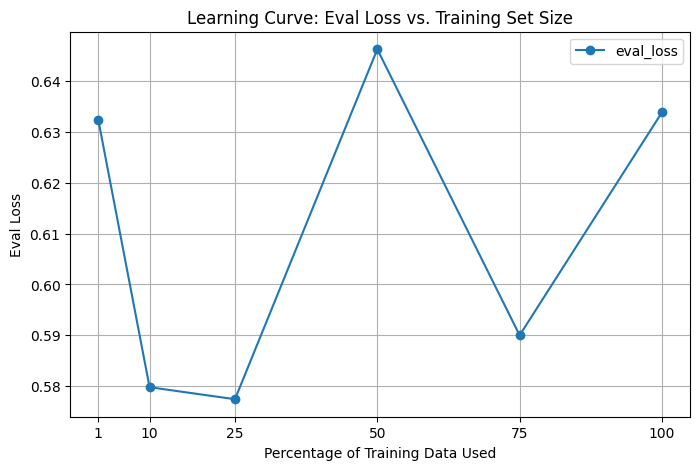

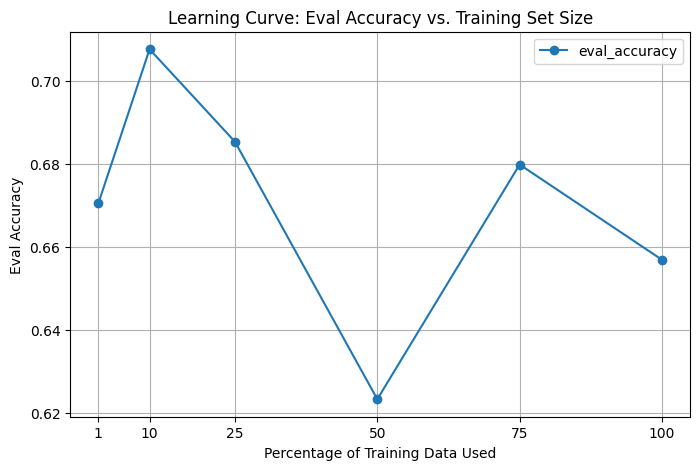

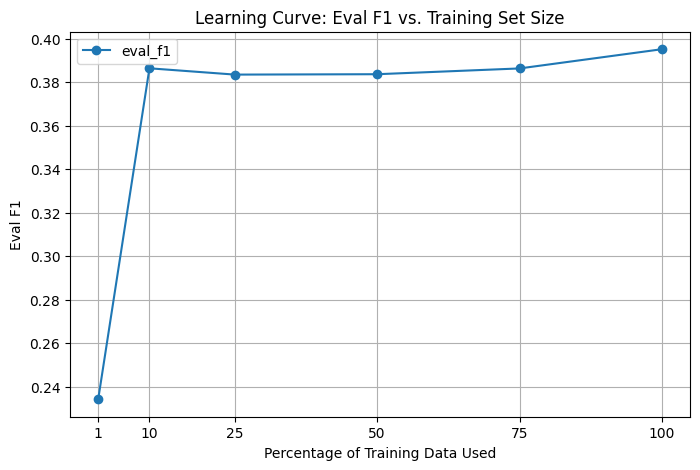

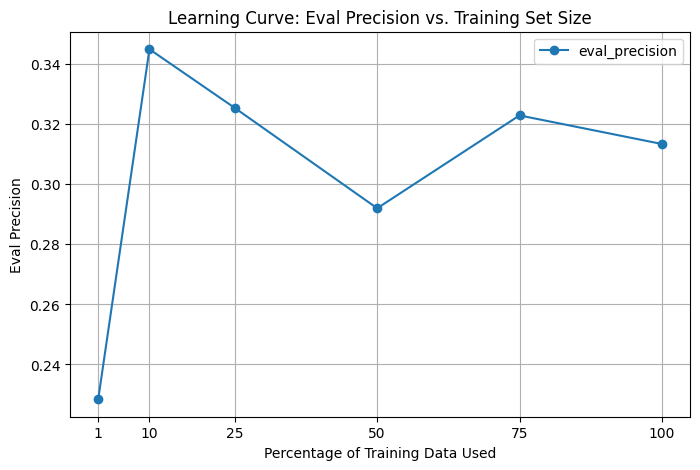

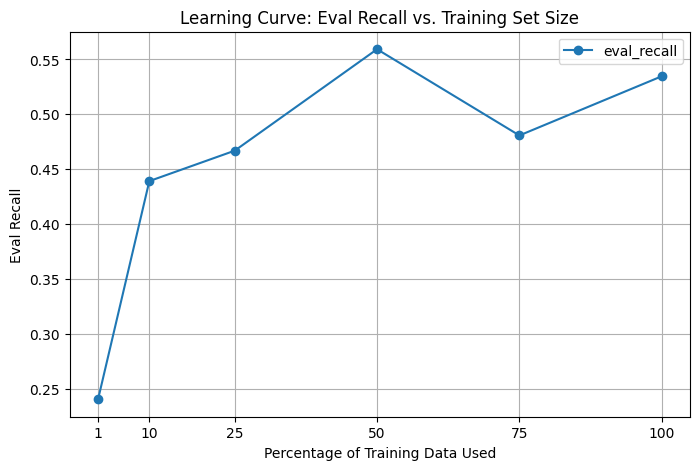

In [18]:
# Plot learning curve for different metrics
metrics = ['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall']
for metric in metrics:
    plot_learning_curve(summary_df, metric)

# 3. Technique Comparison

In [ ]:
import matplotlib.pyplot as plt
from library.incremental_train.doc import run_incremental_training

# Model names
model_names = [
    "almanach/camembert-base",
    "dascim/juribert-base",
    "google-bert/bert-base-multilingual-cased"
]

# Dictionary to store the results
results = {}

# Train each model 
for model_name in model_names:
    print(f"\nEntrenando modelo: {model_name}")
    summary_df = run_incremental_training(
        train_df=train_df,
        valid_df=val_df,
        model_name=model_name,
        max_length=max_length,
        num_labels=num_labels,
        seed=seed
    )
    results[model_name] = summary_df

# Graph the learning curves
def plot_comparison(results, metric='eval_accuracy'):
    plt.figure(figsize=(8, 5))
    for model_name, summary_df in results.items():
        plt.plot(summary_df['percentage'], summary_df[metric], marker='o', label=model_name.split('/')[-1])
    plt.xlabel('Percentage of Training Data Used')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'Learning Curve Comparison: {metric.replace("_", " ").title()}')
    plt.grid(True)
    plt.xticks([1, 10, 25, 50, 75, 100])
    plt.legend()
    plt.show()

# Comparison of accuracy and F1 scores
plot_comparison(results, metric='eval_accuracy')
plot_comparison(results, metric='eval_f1')

# 4. Methodology Analysis